In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing

from sklearn.model_selection import train_test_split

import utils.viztools as viz

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import root_mean_squared_error, r2_score

In [2]:
# Get California housing dataset from sklearn
housing = fetch_california_housing()
df = pd.DataFrame(housing.data)
df['MEDV'] = housing.target

In [3]:
# Define target
target = 'MEDV'

In [4]:
# train, test split
train, test = train_test_split(df, test_size = 0.2, random_state = 42)

In [5]:
# Super mini-EDA
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 14196 to 15795
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       16512 non-null  float64
 1   1       16512 non-null  float64
 2   2       16512 non-null  float64
 3   3       16512 non-null  float64
 4   4       16512 non-null  float64
 5   5       16512 non-null  float64
 6   6       16512 non-null  float64
 7   7       16512 non-null  float64
 8   MEDV    16512 non-null  float64
dtypes: float64(9)
memory usage: 1.3 MB


In [6]:
train.head()

,0,1,2,3,4,5,6,7,MEDV
14196,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03,1.030
8267,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16,3.821
17445,4.1563,4.0,5.645833,0.985119,915.0,2.723214,34.66,-120.48,1.726
14265,1.9425,36.0,4.002817,1.033803,1418.0,3.994366,32.69,-117.11,0.934
2271,3.5542,43.0,6.268421,1.134211,874.0,2.300000,36.78,-119.80,0.965


Consider the distribution of the target and how certain transformations will impact the distribution

/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 16512.
  res = hypotest_fun_out(*samples, **kwds)
/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 16512.
  res = hypotest_fun_out(*samples, **kwds)
/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 16512.
  res = hypotest_fun_out(*samples, **kwds)
/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 16512.
  res = hypotest_fun_out(*samples, **kw

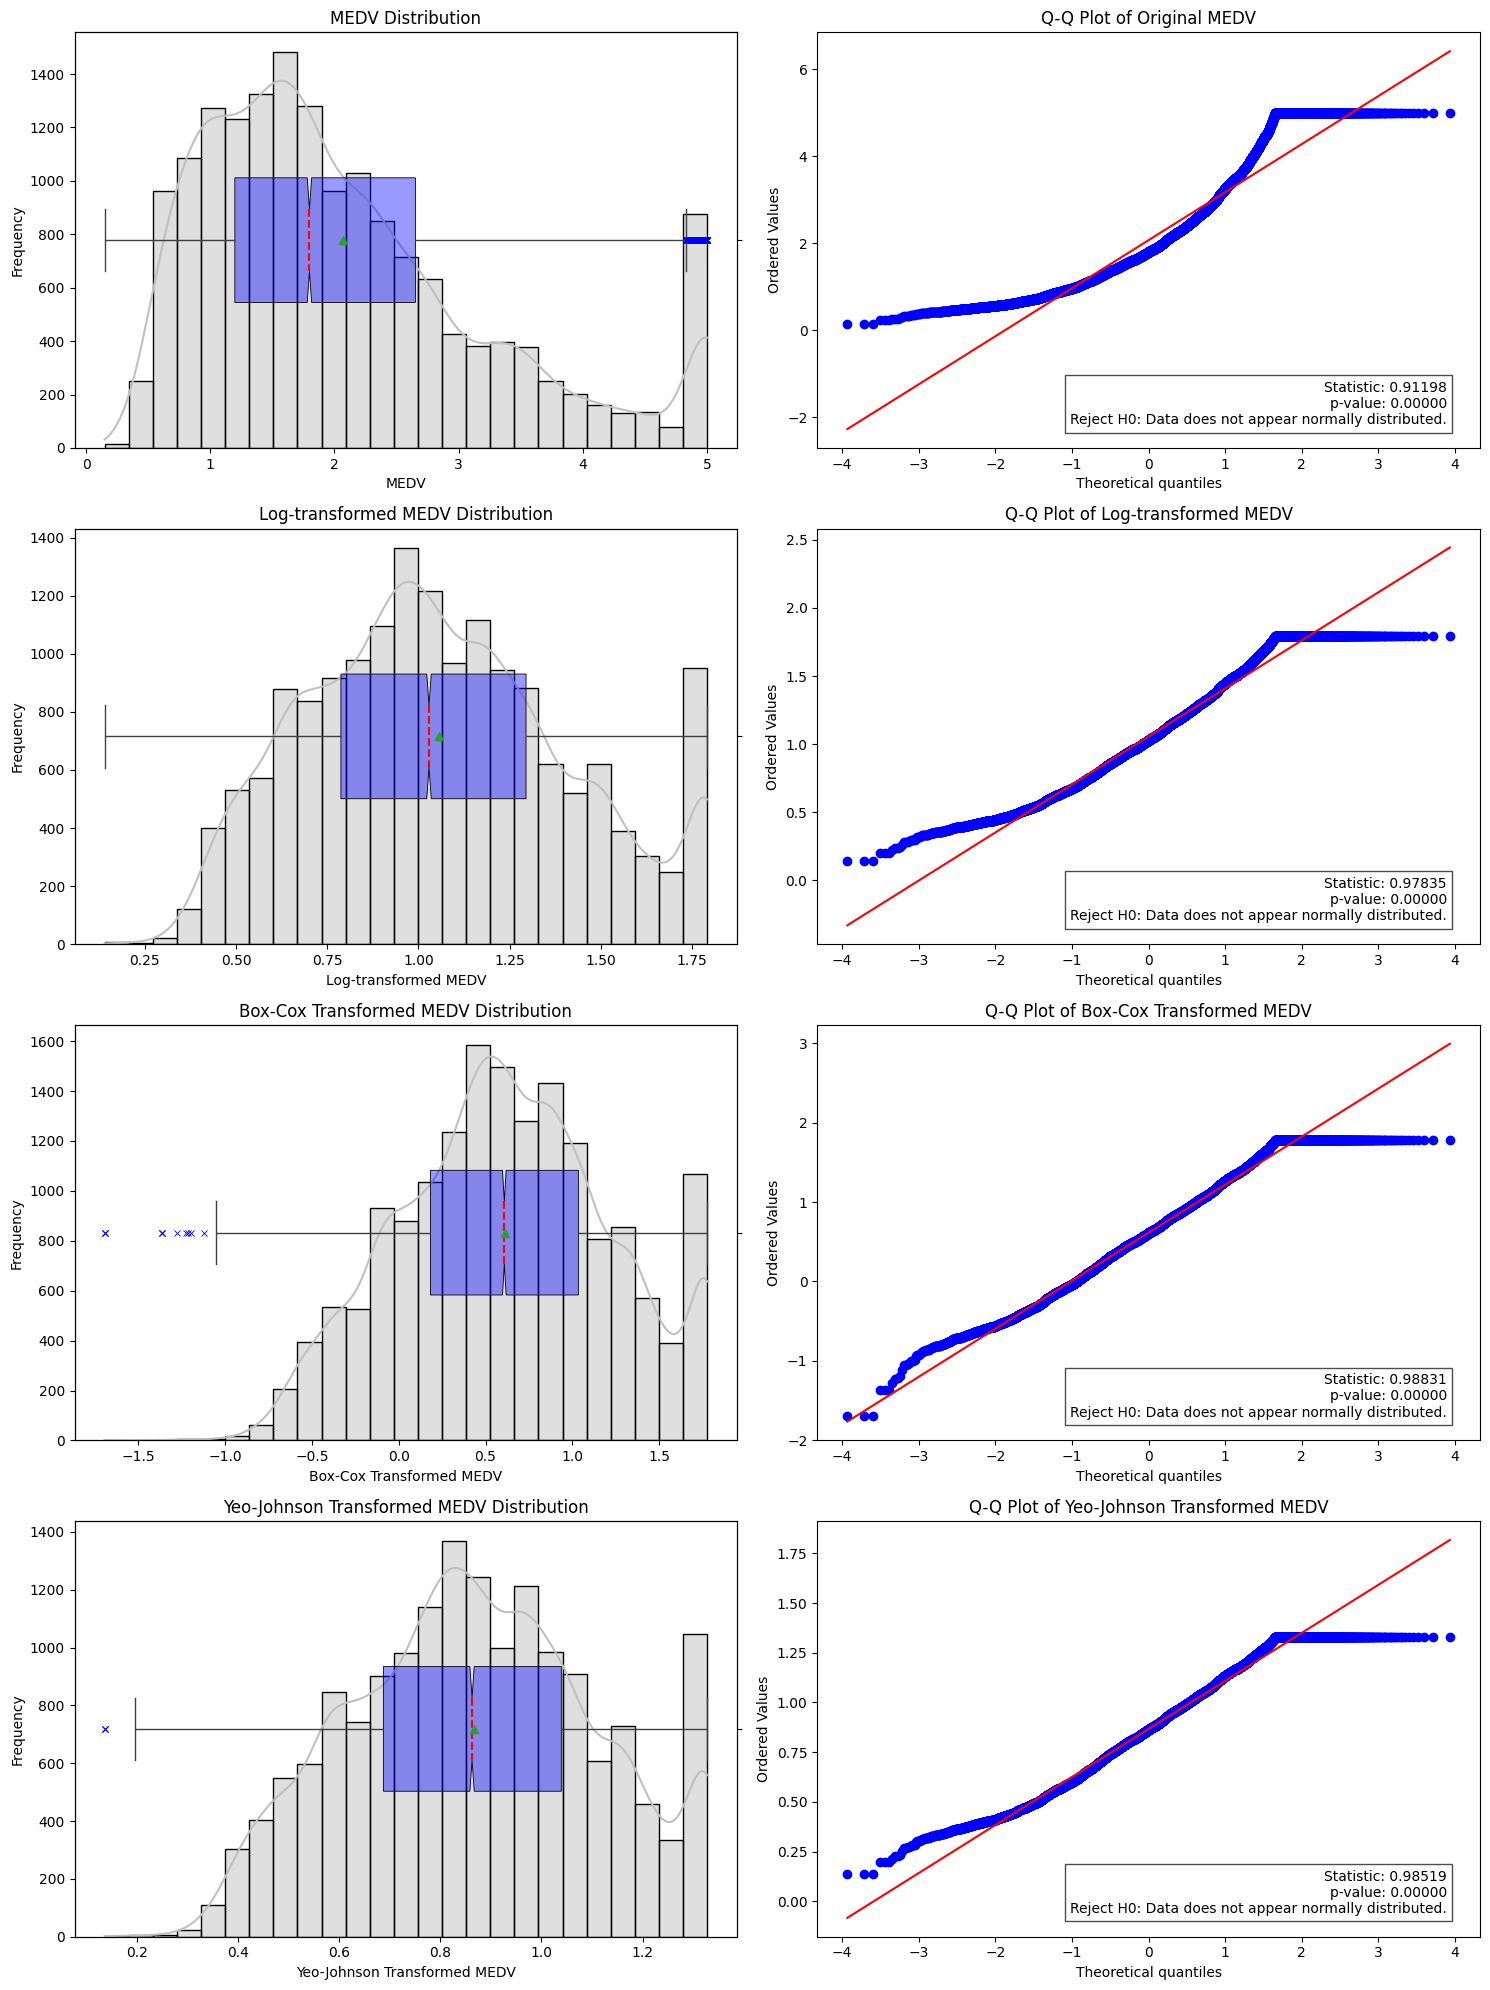

In [7]:
# Function to visualize how transformations impact a given variable
# Q-Q plot with shapiro results help with decision making about transformations
viz.transform_distributions(train, target, transformations = ('log','boxcox','yeo-johnson'))

In [8]:
# Made a function to more easily carry out the transformation and add the transformed feature back into the dataset
# target is the example here, but not necessary given how this can be handled within a pipeline
viz.transform_col(train, target, 'log')

In [9]:
# Considering what to do about outliers, remains a bit of a dark arts mystery to me...
target_95 = train[target].quantile(0.95)
train_outliers = train.copy()
train = train[train[target] <= target_95]

In [10]:
# Get X, y pairs for train and test
X_train, y_train = train.drop([target, 'log_MEDV'], axis = 1), train[target]
X_test, y_test = test.drop(target, axis = 1), test[target]

---
## Function Creation

Maybe worth developing these functions as part of ML toolkit project

In [11]:
# defined a log transformation instead of using a lambda function within a FunctionTransformer
def log_transform(x):
    return np.log1p(x - x.min(axis = 0) + 1)

# Modularized cross_validation and testing on test set
def cv_evaluate(model, X, y):
    
    scoring = ['r2','neg_root_mean_squared_error']
    results = cross_validate(model, X, y, cv = 5, scoring = scoring, return_train_score = False)
    
    mean_r2 = np.mean(results['test_r2'])
    mean_rmse = -np.mean(results['test_neg_root_mean_squared_error'])

    print(f'Mean Cross_validated R2: {mean_r2}')
    print(f'Mean Cross-Validated RMSE: {mean_rmse}')
    return None

def fit_test_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    y_preds = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_preds)
    r2 = r2_score(y_test, y_preds)
    
    print(f'Test data R2 Score: {r2}')
    print(f'Test data RMSE: {rmse}')
    return None

In [12]:
print(df.columns)
print(train.columns)
print(X_train.columns)
print(X_test.columns)

Index([0, 1, 2, 3, 4, 5, 6, 7, 'MEDV'], dtype='object')
Index([0, 1, 2, 3, 4, 5, 6, 7, 'MEDV', 'log_MEDV'], dtype='object')
Index([0, 1, 2, 3, 4, 5, 6, 7], dtype='object')
Index([0, 1, 2, 3, 4, 5, 6, 7], dtype='object')


In [13]:
# define numeric features in dataset
num_features = list(X_train.select_dtypes(include = ['int64', 'float64']).columns)
cat_features = None

---
## Pipeline Building

In [14]:
# 1. Make separate numrical and categorical feature pipelines to handle log transforming features, scaling, oh encoding etc.
num_pipe = Pipeline([
    ('log_transform', FunctionTransformer(log_transform)),
    ('scale', StandardScaler())
])

# cat_pipe = Pipeline([
#     ('ohe', OneHotEncoder(handle_unknown='ignore'))
# ])

# Create ColumnTransformer to direct the specific pipelines to the correct features
preprocessor = ColumnTransformer([
    ('process_num_features', num_pipe, num_features),
    # ('process_cat_features', cat_pipe, cat_features)
    ],
    remainder = 'passthrough')

---
## Log Transformation to Target

In [15]:
# Create the final pipeline, wrapped within a TransformedTargetRegressor
log_model = TransformedTargetRegressor(
    regressor = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())]),
        func = np.log1p, # need to state the function for transforming the target
        inverse_func = np.expm1) # and the inverse function


print('Train Data')
print('-' * 15)
# call function defined above to cross_validate
cv_evaluate(log_model, X_train, y_train)
print()
print('Test Data')
print('-' * 15)
# call function defined above to evaluate on test set
fit_test_evaluate(log_model, X_train, y_train, X_test, y_test)

Train Data
---------------
Mean Cross_validated R2: 0.563464675650725
Mean Cross-Validated RMSE: 0.637440159655881

Test Data
---------------
Test data R2 Score: 0.6040124162712273
Test data RMSE: 0.7203510845345509


---
## Yeo-Johnson transformation to the target

- adds a layer of complexity as can't directly call the fit_transform or inverse_transform methods of PowerTransformer.
- need to define these methods as separate functions
- then add the functions as the arguments for the func and inverse_func parameters of PowerTransformer

In [16]:
pt = PowerTransformer(method = 'yeo-johnson')

def yj_transform(y):
    return pt.fit_transform(y)

def yj_inverse(y):
    return pt.inverse_transform(y)

yeoJohnson_model = TransformedTargetRegressor(
    regressor = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())]),
        func = yj_transform,
        inverse_func = yj_inverse)

print('Train Data')
print('-' * 15)
cv_evaluate(yeoJohnson_model, X_train, y_train)
print()
print('Test Data')
print('-' * 15)
fit_test_evaluate(yeoJohnson_model, X_train, y_train, X_test, y_test)

Train Data
---------------
Mean Cross_validated R2: 0.5622861213422047
Mean Cross-Validated RMSE: 0.6382280854974699

Test Data
---------------
Test data R2 Score: 0.6012329755616486
Test data RMSE: 0.7228747395299021
